# Tutorial: One Machine against Infinite Bus (OMIB)

This tutorial will introduce you to the functionality of `LITS` for running Power System Simulations.
Note that this tutorial is for `LITS 0.4.0`. Current version already have a dedicated function to find an equilibrium point using a Power Flow method without relying in a guess of the initial condition.

This tutorial presents a simulation of a two-bus system, with an infinite bus (represented as a voltage source behind an impedance) at bus 1 and a classic machine on bus 2. The perturbation will be the trip of one of the two circuits (doubling its resistance and impedance) of the line that connects both buses.

## Step 1: Package Initialization

The first step consists in initialize all packages that will be used to run the simulation. All the necessary packages are listed:

In [4]:
using LITS
using PowerSystems
using Sundials
const PSY = PowerSystems

┌ Info: Precompiling LITS [86b0dc02-7903-11e9-325f-f195ca7e6c1a]
└ @ Base loading.jl:1260


PowerSystems

`PowerSystems` is used to properly define the data structure, while `Sundials` is used to solve the problem defined in `LITS`. We used `PSY` to abbreviate the `PowerSystems.jl` package.

## Step 2: Load the system

We will load the system using the a RAW file:

In [5]:
omib_sys = System("Data/OMIB.raw");

┌ Info: The PSS(R)E parser currently supports buses, loads, shunts, generators, branches, transformers, and dc lines
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/pm_io/common.jl:26
┌ Info: the voltage setpoint on generator 1 does not match the value at bus 102
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/pm_io/data.jl:1686
┌ Info: Constructing System from Power Models
│   data["name"] = omib
│   data["source_type"] = pti
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:39
┌ Info: Reading bus data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:140
┌ Info: Reading generator data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_data.jl:418
┌ Info: Reading branch data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/parsers/power_models_da

Now, the RAW file only contains one generator at bus 2, so we will attach an infinite source at bus 1.

In [6]:
#Attach an infinite source at bus 1.
function add_source_to_ref(sys::PSY.System)
    for g in PSY.get_components(StaticInjection, sys)
        isa(g, ElectricLoad) && continue
        g.bus.bustype == BusTypes.REF &&
            error("A device is already attached to the REF bus")
    end

    #Find the Slack bus
    slack_bus = [b for b in PSY.get_components(Bus, sys) if b.bustype == BusTypes.REF][1]
    inf_source = Source(
        name = "InfBus", #name
        available = true, #availability
        active_power = 0.0,
        reactive_power = 0.0,
        bus = slack_bus, #bus
        R_th = 0.0,
        X_th = 5e-6, #Xth
    )
    PSY.add_component!(sys, inf_source)
    return
end

add_source_to_ref(omib_sys)

Now we create the Dynamic Components that Define a Generator:

In [7]:
# Create the Dynamic Components
#Machine
machine_classic() = BaseMachine(
    0.0, #R
    0.2995, #Xd_p
    0.7087, #eq_p
)

#Shaft
shaft_damping() = SingleMass(
    3.148, #H
    2.0, #D
)

#AVR
avr_none() = AVRFixed(0.0)
#TG
tg_none() = TGFixed(1.0) #efficiency
#PSS
pss_none() = PSSFixed(0.0)

function dyn_gen_classic(generator)
    return PSY.DynamicGenerator(
        generator,
        1.0, #ω_ref
        machine_classic(), #machine
        shaft_damping(), #shaft
        avr_none(), #avr
        tg_none(), #tg
        pss_none(), #pss
    ) 
end

dyn_gen_classic (generic function with 1 method)

The function dyn_gen_classic receives a static generator, and creates the dynamic one based on such static model.

In [8]:
#Collect the static gen in the system
static_gen = get_component(Generator, omib_sys, "generator-102-1")
#Creates the dynamic generator
dyn_gen = dyn_gen_classic(static_gen)
#Add the dynamic generator the system
add_component!(omib_sys, dyn_gen);

┌ Warning: struct DynamicGenerator does not exist in validation configuration file, validation skipped
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/uXGZ2/src/validation.jl:55


## Step 3: Build the simulation and initializing the problem

The next step is to create the simulation structure. This will create the indexing of our system that will be used to formulate the differential-algebraic system of equations. To do so, it is required to specify the perturbation that will occur in the system. `LITS` support two types of perturbations:
- Three Phase Fault
- Change in Reference Parameter

In here, he will use a Three Phase Fault, that is modeled by modifying the admittance matrix of the system. To do so we create a ThreePhaseFault perturbation as follows:

In [9]:
#Compute the Y_bus after fault
#Collect the branch of the system as:
fault_branch = deepcopy(collect(get_components(Branch, omib_sys))[1])
#Duplicates the impedance of the reactance
fault_branch.x = fault_branch.x * 2
#Obtain the new Ybus of the faulted system
Ybus_fault = Ybus([fault_branch], get_components(Bus, omib_sys))[:, :]

#Construct the perturbation
perturbation_Ybus = ThreePhaseFault(
    1.0, #change will occur at t = 1.0s
    Ybus_fault, #new Ybus
)

┌ Info: The System has no islands
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/3Pdts/src/utils/network_calculations/ybus_calculations.jl:139


ThreePhaseFault(1.0, 
  [1, 1]  =  0.0-10.0im
  [2, 1]  =  0.0+10.0im
  [1, 2]  =  0.0+10.0im
  [2, 2]  =  0.0-10.0im)

With this, we are ready to create our simulation structure. To construct our simulation we use:

In [10]:
#Time span of our simulation
tspan = (0.0, 30.0)

#Define Simulation
sim = Simulation(
    pwd(), #Folder to save results
    omib_sys, #system
    tspan, #time span
    perturbation_Ybus, #Type of perturbation
)

┌ Info: Serialized time series data to /var/folders/fz/6cnhcl5n2dggz6f6c_l54g740000gn/T/jl_zJUfuY/sys_time_series_storage.h5.
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/uXGZ2/src/time_series_storage.jl:53
┌ Info: Serialized System to /var/folders/fz/6cnhcl5n2dggz6f6c_l54g740000gn/T/jl_zJUfuY/sys.json
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/uXGZ2/src/serialization.jl:8
┌ Info: Loaded time series from storage file existing=sys_time_series_storage.h5 new=/var/folders/fz/6cnhcl5n2dggz6f6c_l54g740000gn/T/jl_L3zmfp
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/uXGZ2/src/hdf5_time_series_storage.jl:82
┌ Warning: struct DynamicGenerator does not exist in validation configuration file, validation skipped
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/uXGZ2/src/validation.jl:55
┌ Warning: There are no ElectricLoad Components in the System
└ @ Pow

Simulation()


This will correctly initialize the system. It essentially will run a power flow and update `V_ref`, `P_ref` and hence `eq_p` (the internal voltage) to match the solution of the power flow. It will also initialize the states in the equilibrium. 

In [11]:
#Will print the initial states. It also give the symbols used to describe those states.
print_device_states(sim)
#Will export a dictionary with the initial condition values to explore
x0_init = get_initial_conditions(sim)

Voltage Variables
BUS 1       
Vm 1.05
θ -0.0
BUS 2       
Vm 1.04
θ 0.0229
Differential States
generator-102-1
δ 0.1685
ω 1.0


Dict{String,Any} with 5 entries:
  "generator-102-1" => Dict(:ω=>1.0,:δ=>0.168525)
  "V_R"             => Dict(102=>1.03973,101=>1.05)
  "Vm"              => Dict(102=>1.04,101=>1.05)
  "θ"               => Dict(102=>0.0228958,101=>-1.27016e-19)
  "V_I"             => Dict(102=>0.0238095,101=>-1.33367e-19)

## Step 4: Run the Simulation

Finally, to run the simulation we simply use:

In [12]:
#Solve problem
run_simulation!(sim, #simulation structure
                IDA(), #Sundials DAE Solver
                dtmax=0.02); #Arguments: Maximum timestep allowed

## Step 5: Exploring the solution

After running the simulation, our simulation structure `sim` will have the solution. For that `sim.solution` can be used to explore the solution structure. In this case `sim.solution.t` returns the vector of time, while `sim.solution.u` return the array of states. In addition, `LITS` have two functions to obtain different states of the solution:

- `get_state_series(sim, ("generator-102-1", :δ))`: can be used to obtain the solution as a tuple of time and the required state. In this case, we are obtaining the rotor angle `:δ` of the generator named `"generator-102-1"`.
- `get_voltagemag_series(sim, 102)`: can be used to obtain the voltage magnitude as a tuple of time and voltage. In this case, we are obtaining the voltage magnitude at bus 102 (where the generator is located).


┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


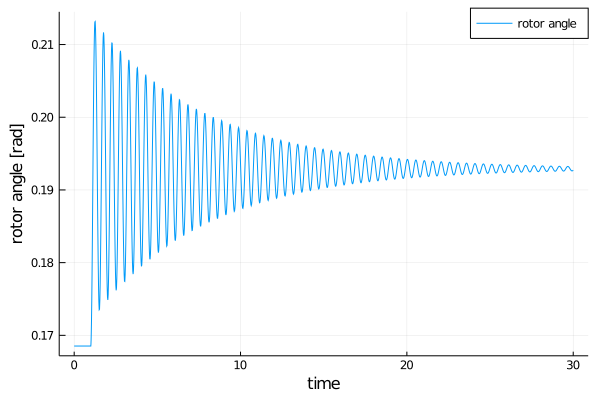

In [13]:
using Plots
angle = get_state_series(sim, ("generator-102-1", :δ))
plot(angle, xlabel="time", ylabel="rotor angle [rad]", label="rotor angle")
#savefig("rotor_angle_OMIB.png")

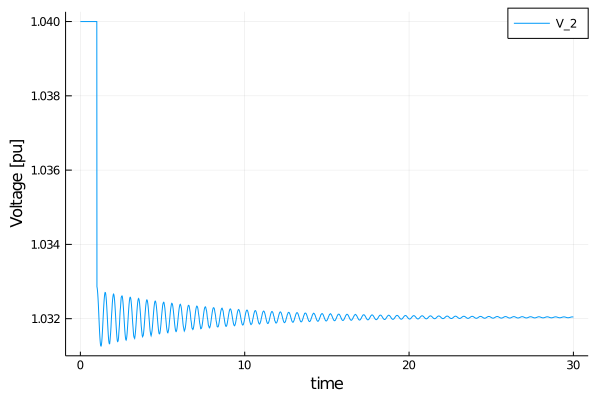

In [14]:
volt = get_voltagemag_series(sim, 102)
plot(volt, xlabel="time", ylabel="Voltage [pu]", label="V_2")
#savefig("voltage_OMIB.png")

## Optional: Small Signal Analysis

`LITS 0.4.0` uses automatic differentiation to compute the reduced Jacobian of the system for the differential states. This can be used to analyze the local stability of the linearized system.


In [15]:
small_sig = small_signal_analysis(sim)

The system is small signal stable


The `small_sig` result can report the reduced jacobian for $\delta$ and $\omega$, and can also be used to report the eigenvalues of the reduced linearized system.


In [16]:
small_sig.reduced_jacobian

small_sig.eigenvalues

2-element Array{Complex{Float64},1}:
 -0.15883100381194404 - 12.443054974468177im
 -0.15883100381194404 + 12.443054974468177im